<a href="https://colab.research.google.com/github/mobarakol/UNet3D/blob/main/SVLS_BraTS_Demo_IPMI2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Spatially Varying Label Smoothing: Capturing Uncertainty from Expert Annotations

In [1]:
!rm -rf UNet3D
!git clone https://github.com/mobarakol/UNet3D.git
%cd UNet3D

Cloning into 'UNet3D'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 49 (delta 20), reused 28 (delta 9), pack-reused 0
Unpacking objects: 100% (49/49), done.
/content/UNet3D


Install require packages:

In [2]:
!pip install -U -q SimpleITK

     |████████████████████████████████| 47.4MB 61kB/s 


### Download Dataset and Trained Models

In [3]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Trained Models: https://drive.google.com/file/d/1evE2VqBGdY-0VPB8OeArHMPdRXhWuxFm/view?usp=sharing <br>
Validation Data: https://drive.google.com/file/d/1oZ9z-l9lBjKGNZCCTK819Z1ufwe90mg3/view?usp=sharing

In [4]:
ids = ['1evE2VqBGdY-0VPB8OeArHMPdRXhWuxFm', '1oZ9z-l9lBjKGNZCCTK819Z1ufwe90mg3']
zip_files = ['ckpt_brats19.zip','train_valid.zip']
for id, zip_file in zip(ids, zip_files):
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile(zip_file)
    !unzip -q $zip_file

Demo

Length of dataset- valid: 66
model:best_oh.pth.tar , dice[ET:0.802 ± 0.180, TC:0.862 ± 0.126, WT:0.892 ± 0.074], ECE:0.0732, TACE:0.0041
model:best_oh.pth.tar , Surface dice[ET:0.916 ± 0.197, TC:0.862 ± 0.179, WT:0.894 ± 0.151]
model:best_ls0.1.pth.tar , dice[ET:0.825 ± 0.154, TC:0.873 ± 0.130, WT:0.893 ± 0.070], ECE:0.0646, TACE:0.0025
model:best_ls0.1.pth.tar , Surface dice[ET:0.935 ± 0.167, TC:0.891 ± 0.168, WT:0.913 ± 0.119]
model:best_ls0.2.pth.tar , dice[ET:0.804 ± 0.177, TC:0.863 ± 0.131, WT:0.896 ± 0.064], ECE:0.0958, TACE:0.0049
model:best_ls0.2.pth.tar , Surface dice[ET:0.929 ± 0.183, TC:0.881 ± 0.179, WT:0.912 ± 0.120]
model:best_ls0.3.pth.tar , dice[ET:0.788 ± 0.209, TC:0.858 ± 0.163, WT:0.893 ± 0.068], ECE:0.1459, TACE:0.0073
model:best_ls0.3.pth.tar , Surface dice[ET:0.914 ± 0.194, TC:0.872 ± 0.190, WT:0.920 ± 0.113]
model:best_svls.pth.tar , dice[ET:0.816 ± 0.135, TC:0.862 ± 0.119, WT:0.894 ± 0.065], ECE:0.0630, TACE:0.0040
model:best_svls.pth.tar , Surface dice[ET:0.937

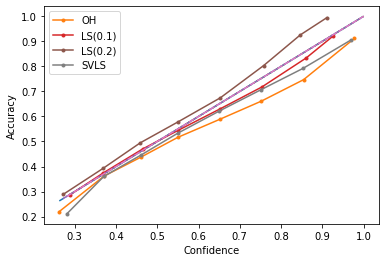

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import numpy as np
import random
import argparse
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
from dataset_brats import dataset_brats19
from model import UNet3D
from utils import dice_3D, seed_everything, worker_init_fn, EDiceLoss
from calibration_metrics import ece_eval, tace_eval, reliability_diagram
import warnings
warnings.filterwarnings("ignore")
device = 'cuda' if torch.cuda.is_available() else 'cpu'


def step_valid(data_loader, model, metric):
    ece_all, acc_all, conf_all, Bm_all, tace_all = [], [], [], [], []
    losses, metrics, metrics_sd = [], [], []
    model.eval()
    for i, batch in enumerate(data_loader):
        inputs, targets,_ = batch
        targets = targets.squeeze().cuda(non_blocking=True)
        inputs = inputs.float().cuda()
        segs = model(inputs)
        outputs = F.softmax(segs, dim=1).detach().cpu().numpy()
        if len(targets.shape) < 4:#if batch size=1
            targets = targets.unsqueeze(0)
        labels = targets.detach().cpu().numpy()
        
        ece, acc, conf, Bm = ece_eval(outputs,labels)
        tace, _, _, _ = tace_eval(outputs,labels)
        ece_all.append(ece)
        acc_all.append(acc)
        conf_all.append(conf)
        Bm_all.append(Bm)
        tace_all.append(tace)
        segs = segs.data.max(1)[1].squeeze_(1)
        metric_ = metric.metric_brats(segs, targets)
        metrics_sd.extend(metric.get_surface_dice(segs.detach().cpu().numpy(), targets.detach().cpu().numpy()))
        metrics.extend(metric_)

    ece_avg = np.stack(ece_all).mean(0)
    acc_avg = np.stack(acc_all).mean(0)
    conf_avg = np.stack(conf_all).mean(0)
    Bm_avg = np.stack(Bm_all).mean(0)
    tace_avg = np.stack(tace_all).mean(0)
    return metrics, metrics_sd, ece_avg, acc_avg, conf_avg, Bm_avg, tace_avg

def main():
    parser = argparse.ArgumentParser(description='Brats Training')
    parser.add_argument('--num_classes', default=4, type=int, help="num of classes")
    parser.add_argument('--in_channels', default=4, type=int, help="num of classes")
    parser.add_argument('--batch_size', default=2, type=int,help='mini-batch size')
    parser.add_argument('--lr', default=1e-4, type=float,help='initial learning rate')
    parser.add_argument('--crop_xy', default=192, type=int, help="crop dimension in x and y")
    parser.add_argument('--crop_z', default=128, type=int, help="crop dimension in z")
    parser.add_argument('--init_xy', default=24, type=int, help="initial position of x and y")
    parser.add_argument('--init_z', default=17, type=int, help="initial position of z")
    parser.add_argument('--data_root', default='', help='data root')
    parser.add_argument('--sd_tolerance', default=[1,2], type=int, help="Surface dice tolerance")
    parser.add_argument('--spacing_mm', default=(1,1,1), type=int, help="Surface dice spacing")
    parser.add_argument('--ckpt_dir', default='ckpt_brats19/', help='data root')
    args = parser.parse_args(args=[])

    dataset_valid = dataset_brats19(args=args, isTrain=False)
    valid_loader = DataLoader(dataset=dataset_valid, batch_size=args.batch_size, shuffle=False, num_workers=2,
                               worker_init_fn=worker_init_fn)
    
    print('Length of dataset- valid:', dataset_valid.__len__())
    model = UNet3D(in_channels=args.in_channels, out_channels=args.num_classes, isSoftmax=False).to(device)
    model = torch.nn.parallel.DataParallel(model)
    criterion_dice = EDiceLoss().to(device)
    metric = criterion_dice.metric_brats
    legends = ['OH', 'LS(0.1)', 'LS(0.2)', 'LS(0.3)', 'SVLS']
    model_list = ['best_oh.pth.tar', 'best_ls0.1.pth.tar', 'best_ls0.2.pth.tar', 'best_ls0.3.pth.tar', 'best_svls.pth.tar']
    for model_name, legend in zip(model_list, legends):
        model.load_state_dict(torch.load(args.ckpt_dir + str(model_name)))
        model.eval()
        with torch.no_grad():
            dice_metrics, metrics_sd, ece_avg, acc_avg, conf_avg, Bm_avg, tace_avg = step_valid(valid_loader, model, criterion_dice)
        if legend != 'LS(0.3)':
            reliability_diagram(conf_avg, acc_avg, legend=legend)
        dice_metrics = list(zip(*dice_metrics))
        dice_metrics = [torch.tensor(dice, device="cpu").numpy() for dice in dice_metrics]
        avg_dices = np.mean(dice_metrics,1)
        avg_std = np.std(dice_metrics,1)

        metrics_sd = list(zip(*metrics_sd))
        metrics_sd = [torch.tensor(dice, device="cpu").numpy() for dice in metrics_sd]
        avg_sd = np.mean(metrics_sd,1)
        avg_std_sd = np.std(metrics_sd,1)

        print('model:%s , dice[ET:%.3f ± %.3f, TC:%.3f ± %.3f, WT:%.3f ± %.3f], ECE:%.4f, TACE:%.4f'%(
            model_name, avg_dices[0],avg_std[0], avg_dices[1],avg_std[1], avg_dices[2],avg_std[2], ece_avg, tace_avg))
        
        print('model:%s , Surface dice[ET:%.3f ± %.3f, TC:%.3f ± %.3f, WT:%.3f ± %.3f]'%(
            model_name, avg_sd[0],avg_std_sd[0], avg_sd[1],avg_std_sd[1], avg_sd[2],avg_std_sd[2]))

if __name__ == '__main__':
    seed_everything()
    main()